In [41]:
!bash ./init.sh 

  Using cached tqdm-4.65.0-py3-none-any.whl (77 kB)


In [52]:
# Import libraries needed in the lab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from utils import seed_everything
seed = 42 # set a random seed for random operatioons to make results reproducible
seed_everything(seed)

import warnings
warnings.filterwarnings('ignore')

%reload_ext autoreload
%autoreload 2

# Uncertainty quantification and active learning

_by S Luukkonen_

In this practical, we will look at two emerging concepts in machine learning: [uncertainty quantification](https://en.wikipedia.org/wiki/Uncertainty_quantification) and [active learning](https://en.wikipedia.org/wiki/Active_learning_(machine_learning)). 

# Theory

## Uncertainty quantification in regression

Most ML-based QSAR prediction models are “black boxes” giving single y-predictions (regression) or
y-classes (classification) without any indication of the quality of a single prediction. They are difficult to
interpret, are susceptible to pathological failures in out-of-domain regimes and lack guarantees of their
robustness. The importance of uncertainty estimation when models are used for decision making, has been noted in the _computationally aided drug discovery_ community, but its systematic use is lacking [[Begoli, 2019](https://doi.org/10.1038/s42256-018-0004-1), [Mervin, 2021](https://10.1016/j.drudis.2020.11.027)].

In this pratical we will concentrate on uncertainty quantification in regression models, but there is a short theory [section](#uncertainty-quantification-in-classification-models) on uncertainty calibration of classiers.

### Aletoric and epistemic uncertainty

The uncertainty in a ML model prediction comes from two source:
- Aleatoric (also know as stochastic uncertainty) that comes from the noise in the data (_i.e._ the experimental error of bioactivity measures in this cases)
- Epistemic (also know as systematic uncertainty) which is the uncertainty of the model often due to lack of training data (you might be trying to use a model out of its domain of applicability) but is also affected by the suitability of model architecture (a too simple or complex model can lead to large uncertainty).

![image](images/aletoric_epistemic_uncertainty.PNG)
_From [Amini et al., 2019](https://proceedings.neurips.cc/paper/2020/hash/aab085461de182608ee9f607f3f7d18f-Abstract.html)_

**TO DO : continue introduction on different approaches for uncertainty quantitification >> define termes mean and variance + note that the commonly used RF method is an ensemble >> automatic epistemic uncertainty prediction**


### Total uncertainty in regression models

In this practical, we used methods that could either quantify the aletoric or epistemic uncertainty. However, there approaches that can model both uncertanties simultaneously such as [Gaussian process regression](https://en.wikipedia.org/wiki/Kriging) and [evidential learning](https://proceedings.neurips.cc/paper/2020/hash/aab085461de182608ee9f607f3f7d18f-Abstract.html), or we can approximate the predictive variance as a combination of aletoric and epistemic uncertanties from the MVE and Baysien neural network (approximated here with the MC dropout).

### Evaluation of the uncertainty estimations



Note that all the methods discussed above are approximate estimates of the uncertainty, and therefore, they are not perfect and their quality should be evaluated.

We can visually evalute the quality by
- a _**calibration curve**_ which plots the fraction of correctly observed output labels as a function of the expected fraction correctly. _Eg._ we expect 68% of the predictions to be within one standard deviation away (derived from their predicted variance) of their mean prediction. If the true fraction is higher the models is under-confident (_i.e_ predicting too large error bars), and if its below the model is over-confident (_i.e_ predicting too small error bars). Overall, closer to the identity line to curve the better the model is calibrated.
- a _**RMSE-drop curve**_ which plot the cumulative root-mean-squered error as the function the confidence (molecules ranked based on the uncertainty estimation). Larger the drop in the curve at higher confidence, the better the calibration.

**TO DO add figure of calibration curve and RMSE drop**

There are also metrics to evaluate the quality
- _**miscalibration area (MCA)**_ - the area between the calibration curve and the identity line. The lower, the better.
- _**Spearman's rank correlation coefficient (rho)**_ between the estimated uncertainty and the absolute error. The higher, the better.
- _**expected normalized calibration error (ENCE)**_ averages the calibration error for binned predictions (based on predicted variance), normalized by the bin’s mean predicted variance, since for a larger variance, we expect naturally larger errors. The lower, the better.

## Uncertainty quantification in classification models

_As additional information, not part of the practical (can be skipped)_

The raw output of classifier is probabalistic and thus inherently includes an estimation of uncertainty. For binary classifiers, the probablistic output is a contineous value between 0 and 1. The closer the value is to 0 or 1, the more confident the model is in its predictions to belong to the negative or postive class, respectively. Whereas closer the value is to 0.5, the less confident the model is in its prediction.

However, usually, the probabilistic outputs are rounded to binary values, losing all information of uncertainty. Moreover, using the probabilistic output is not necessarily a well-calibrated probability that can be used as a good estimation of the uncertainty. Thus, the model calibration should be evaluated (and potentially corrected). 

### Accuracy, discrimination and calibration

- [Accuracy](https://en.wikipedia.org/wiki/Sensitivity_and_specificity) measures the ratio of correctly predicted binary predictions 
- [Discrimination](https://en.wikipedia.org/wiki/Receiver_operating_characteristic) measures the the model's ability to differentiate between postive classes from negative ones
- [Calibration](https://scikit-learn.org/stable/modules/calibration.html) measures the agreement between the frequency of observed events with the predicted probabilities

Usually, the performance of a binary classifier is measured by its accuracy (overall accuracy, specificity, sensitivity, Matthew’s correlation coefficient, ect.) or its capacity to discriminate (ROC, AUC), but verifying the calibration of the model is often omitted.

### Evaluation of calibration

The quality of calibration can be visually checked with a calibration curves (also known as reliability diagrams) which plots the true frequency of the positive label (_i.e._ fraction of positives) against its predicted probability, for binned predictions (_i.e._ mean predicted probability in each bin). Closer the the curve is to the identity line, the better calibrated the model is.

**TODO : add illustration of calibration curve with well- and poorly calibrated models with Brier score values**

The quality of the calibration can also be quantified with calibration error (also called [Brier score](https://en.wikipedia.org/wiki/Brier_score)) which measure the accuracy of prediction against its predicted probability, for binned predictions. 


### Prediction calibration
There as several techiniques to several ways to calibrate prediction by using a s using a validation set to learn a transformation of
their output score, _eg._ [Platt scaling](https://home.cs.colorado.edu/~mozer/Teaching/syllabi/6622/papers/Platt1999.pdf) or [isotonic regression](https://dl.acm.org/doi/10.1145/775047.775151).



## Active learning

**TO DO theory section on active learning**

# Practical

## Data pre-processing and visualization

As data, we will use molecules from a small dataset of 700 monoglyceride lipase (MGLL, [Q99685](https://www.uniprot.org/uniprotkb/Q99685/entry)) bioactivity measures `Q99685_papyrus.tsv`. This data was retrieved from [Papyrus](https://doi.org/10.1186/s13321-022-00672-x) and the `pChEMBL_values_Mean` values correspond to experimental activity measures coming from a variety of assays run in different laboratories under different assay conditions or even by different methods. This makes the data quite noisy as the standard experimental uncertainty is estimated to be around 0.5 pChEMBL units [[Kramer, 2012](https://doi.org/10.1021/jm300131x)].

Thus to make it easier, in this practical, we will create predicition task without noise (i.e. no experimental/aletoric uncertainty) for these molecules. We can use for example the calculate partition coefficent (clogP). It is a simulated logP prediction calculated with an exact formula depeding only the chemical composition of the compound and thus is noiseless. Here we calculate the clogP with `rdkit`.

_Remark: the bioactivity data with the experimental noise will be used in the assignement_

### Output lables

Lets load the molecules from the MGLL dataset,

In [93]:
data = pd.read_csv('Q99685_papyrus.tsv', sep='\t')
data.head()

,Activity_ID,Quality,source,CID,SMILES,connectivity,InChIKey,InChI,InChI_AuxInfo,target_id,...,type_other,Activity_class,relation,pchembl_value,pchembl_value_Mean,pchembl_value_StdDev,pchembl_value_SEM,pchembl_value_N,pchembl_value_Median,pchembl_value_MAD
0,AADKPDGTJHDJAJ_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.177735;ChEMBL31.compound.177...,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,AADKPDGTJHDJAJ,AADKPDGTJHDJAJ-UHFFFAOYSA-N,InChI=1S/C18H18O3/c19-18(21-13-17-12-20-17)11-...,"""AuxInfo=1/0/N:12,11,13,10,14,6,15,5,16,8,3,20...",Q99685_WT,...,NaN,NaN,=,5.62;4.8;4.4;4.81;5.61;5.62;4.8;4.4;4.81;5.61;...,5.048,0.498647,0.111501,20.0,4.81,0.41
1,AAVJAASROXWJAI_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.399047,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,AAVJAASROXWJAI,AAVJAASROXWJAI-UHFFFAOYSA-N,InChI=1S/C23H31NO3/c1-3-4-5-6-7-8-9-10-22(24-2...,"""AuxInfo=1/0/N:1,24,2,3,4,5,6,7,8,9,20,26,17,2...",Q99685_WT,...,NaN,NaN,=,4.44;4.44,4.440,0.000000,0.000000,2.0,4.44,0.00
2,AAZGPNZTJLHQJM_on_Q99685_WT,High,ExCAPE-DB,599019;ChEMBL31.compound.123531;599019;ChEMBL3...,O=C1C=CC(=O)N1c1ccccc1I,AAZGPNZTJLHQJM,AAZGPNZTJLHQJM-UHFFFAOYSA-N,InChI=1S/C10H6INO2/c11-7-3-1-2-4-8(7)12-9(13)5...,"""AuxInfo=1/0/N:11,10,12,9,3,4,13,8,2,5,14,7,1,...",Q99685_WT,...,NaN,NaN,=,5.3;5.3;5.3;5.3;5.3;5.3;5.3;5.3,5.300,0.000000,0.000000,8.0,5.30,0.00
3,ABAMRMYDBGTLHX_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.123534,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,ABAMRMYDBGTLHX,ABAMRMYDBGTLHX-UHFFFAOYSA-N,InChI=1S/C16H11NO2/c18-15-10-11-16(19)17(15)14...,"""AuxInfo=1/0/N:17,16,18,11,10,15,19,12,9,3,4,1...",Q99685_WT,...,NaN,NaN,=,5.81;5.81;5.81;5.81,5.810,0.000000,0.000000,4.0,5.81,0.00
4,AGLVDKDFDZSFKB_on_Q99685_WT,High,ChEMBL31,ChEMBL31.compound.467736,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,AGLVDKDFDZSFKB,AGLVDKDFDZSFKB-UHFFFAOYSA-N,InChI=1S/C18H22ClFN2O4/c19-15-9-13(20)1-3-16(1...,"""AuxInfo=1/1/N:22,4,23,3,12,24,11,25,19,14,6,1...",Q99685_WT,...,NaN,NaN,=,6.72;6.72,6.720,0.000000,0.000000,2.0,6.72,0.00


and create output labels by calculating the clogP values for the molecules,

<Axes: ylabel='Frequency'>

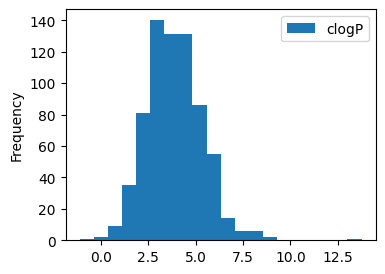

In [94]:
from rdkit import Chem
from rdkit.Chem import Descriptors

# New column with the clogP value
# Each SMILES string is converted to a rdkit molecule object and the clogP value is calculated 
# using the MolLogP function from the rdkit.Chem.Descriptors module
data['clogP'] = data['SMILES'].apply(lambda x: Descriptors.MolLogP(Chem.MolFromSmiles(x)))

# Plot the histogram of the clogP values with pandas plot function
data.plot.hist(y='clogP', bins=20, figsize=(4, 3))

In [95]:
# Lets drop all other columns except the SMILES and clogP columns
data = data[['SMILES', 'clogP']]
data.head()

,SMILES,clogP
0,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,2.7619
1,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,6.3868
2,O=C1C=CC(=O)N1c1ccccc1I,1.7206
3,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,2.7830
4,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,2.9851


### Input features

As you have learn by now, there are a variety of molecular descriptors that can be used to as input features of a QSPR model. In this practical we will use the [MACCS keys](https://doi.org/10.1021/ci010132r), a binary molecular fingerprint of 167 bits, calculated with `rdkit`.

In [96]:
from rdkit.Chem import MACCSkeys

# New column with the MACCS keys
# Each SMILES string is converted to a rdkit molecule object and the MACCS keys are calculated
# using the GenMACCSKeys function from the rdkit.Chem.MACCSkeys module
data['MACCS'] = data['SMILES'].apply(lambda x: MACCSkeys.GenMACCSKeys(Chem.MolFromSmiles(x)))
data.head()

,SMILES,clogP,MACCS
0,O=C(Cc1ccc(Cc2ccccc2)cc1)OCC1CO1,2.7619,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,CCCCCCCCCC(=NO)c1c(O)ccc(-c2ccc(OC)cc2)c1,6.3868,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,O=C1C=CC(=O)N1c1ccccc1I,1.7206,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,O=C1C=CC(=O)N1c1ccccc1-c1ccccc1,2.7830,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,O=C1CCC(COC(=O)N2CCC(COc3c(Cl)cc(F)cc3)CC2)N1,2.9851,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### Data splits

Next we split the data into three subsets:
- training set (50%) - the initial training set
- learning set (30%) -  a set from which the model can select new training data points during the active learning process
- test set (20%) - independant test set used to evaluate the model

In [97]:
from sklearn.model_selection import train_test_split

indices = np.arange(data.shape[0])

# Split the data into train and test sets
train_idx, test_idx = train_test_split(indices, test_size=2/10, random_state=seed)

# Split the train set into train and learn sets
train_idx, learn_idx = train_test_split(train_idx, test_size=3/8, random_state=seed)

# Create a new column with the subset name
data.loc[train_idx, 'Subset'] = 'Train'
data.loc[learn_idx, 'Subset'] = 'Learn'
data.loc[test_idx, 'Subset'] = 'Test'

## Uncertainty quantification

In this practical, we will use a neural network model with combined with too uncertainty quantification methods:
- [Mean-variance estimation](https://ieeexplore.ieee.org/document/374138) to estimate the aleatoric uncertainty. Instead of single output node the neural network has two output nodes.  One corresponding to the mean prediction and the other to estimated aleatoric uncertainty. 

- [Monte Carlo dropout](https://arxiv.org/abs/1506.02142) as an approximate a Bayesian network to measure the epistemic uncertainty of the model. During prediction multiple forward passes are done where at each pass a different subset of nodes are masked. Thus, we get a set of predictions for each molecules, from which we can estimate the mean and the epistemic uncertainty.

![image](images/MVE_MCdropout.PNG)

### Common models hyperparameters

Lets define some common model hyperparameters for all models for consistency

In [16]:
BATCH_SIZE = 128
EPOCHS = 100
INPUT_SIZE = 167 # Length of the MACCS keys
HIDDEN_SIZE = 64

### Dataloaders

For the section on the uncertainty quantification, we will only use the train and test subsets. Lets create `torch.Dataloader`s for both the bioactivity and logP predictions:

In [17]:
from utils import create_dataloader

train_loader = create_dataloader(data, 'Train', 'clogP', 'MACCS', batch_size=BATCH_SIZE)
test_loader = create_dataloader(data, 'Test', 'clogP', 'MACCS', batch_size=BATCH_SIZE)

### Helper function to evaluate the uncertainty quantification

In [18]:
def plot_variance_distribution(variance, title):
    
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.hist(variance, bins=50, density=True, ec='k', histtype='stepfilled'  )
    ax.axvline(variance.mean(), color='k', linestyle='--', linewidth=2, label=f'Mean: {variance.mean():.2f}')
    ax.axvline(variance.median(), color='k', linestyle='-', linewidth=2, label=f'Median: {variance.median():.2f}')
    ax.set_xlabel('Variance')
    ax.set_ylabel('Density')
    ax.set_title(title)
    ax.grid(linestyle='--', alpha=0.5)
    ax.legend()

In [19]:
from scipy.stats import norm, spearmanr
from scipy.integrate import simps

def compute_calibration_curve(y_true, y_mean, y_var, step=0.01):

    """
    Computes the calibration curve and the miscalibration area (MCA) for a given set of predictions.

    Parameters
    ----------
    y_true : numpy array
        True values of the target variable.
    y_mean : numpy array
        Mean of the predicted values of the target variable.
    y_var : numpy array
        Variance of the predicted values of the target variable.

    Returns
    -------
    expected_frac : numpy array
        Expected fraction of samples in each bin.
    real_frac : numpy array
        Real fraction of samples in each bin.
    mca : float
        Miscalibration area.
    """

    expected_frac = np.array( [ 2*i for i in np.arange(0,0.5+step,step) ] )  
    nmols = len(y_true)
    real_frac = []
    for j in range(len(expected_frac)):
        plow = 0.5 - expected_frac[j] / 2
        pup = 0.5 + expected_frac[j] / 2
        cum = 0
        for k in range(nmols):
            if norm.ppf(plow, loc=y_mean[k], scale=y_var[k]) <= y_true[k] <= norm.ppf(pup, loc=y_mean[k], scale=y_var[k]): cum += 1            
        real_frac.append(cum/nmols)

    c_norm = simps(np.array(expected_frac))
    cal_diff = np.abs(real_frac-expected_frac)
    mca = simps(cal_diff/c_norm)
    
    return expected_frac, real_frac, mca

def plot_calibration_curve(y_true, y_mean, y_var):

    """
    Plots the calibration curve and the miscalibration area (MCA) for a given set of predictions.

    Parameters
    ----------
    y_true : numpy array
        True values of the target variable.
    y_mean : numpy array
        Mean of the predicted values of the target variable.
    y_var : numpy array
        Variance of the predicted values of the target variable.
    """

    expected_frac, real_frac, mca = compute_calibration_curve(y_true, y_mean, y_var)
    
    fig, ax = plt.subplots(figsize=(4, 4))

    ax.plot(expected_frac, real_frac, '-', label='MCA = {:.2f}'.format(mca))
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect calibration')
    ax.set_xlabel('Expected fraction')
    ax.set_ylabel('Observed fraction')

    ax.legend(loc='lower right')
    ax.grid(linestyle='--', alpha=0.5)


In [20]:
def compute_spearmanr(y_true, y_mean, y_var):

    """
    Computes the Spearman rank correlation coefficient betweem the predicted 
    variance and the absolute error for a given set of predictions.

    Parameters
    ----------
    y_true : numpy array
        True values of the target variable.
    y_mean : numpy array
        Mean of the predicted values of the target variable.
    y_var : numpy array
        Variance of the predicted values of the target variable.

    Returns
    -------
    spearmanr : float
        Spearman rank correlation coefficient.
    """

    absolute_error = np.abs(y_true - y_mean)
    spearmanr = spearmanr(absolute_error, y_var)[0]
    
    return spearmanr

In [21]:
from sklearn.metrics import mean_squared_error

def compute_ence(y_true, y_mean, y_var, bins=10):

    """
    Computes the expected normalized calibration error (ENCE) for a given set of predictions.

    Parameters
    ----------
    y_true : numpy array
        True values of the target variable.
    y_mean : numpy array
        Mean of the predicted values of the target variable.
    y_var : numpy array
        Variance of the predicted values of the target variable.
    bins : int, optional
        Number of bins to use for the ENCE calculation.

    Returns
    -------
    ence : float
        Expected normalized calibration error.
    """

    ranked_confidence_list = np.argsort(y_var, axis=0).flatten()

    # Split the data into bins
    bin_size = int(len(ranked_confidence_list) / bins)
    bin_list = [ranked_confidence_list[i:i+bin_size] for i in range(0, len(ranked_confidence_list), bin_size)]

    # Compute mean variance and RMSE for each bin
    ence = 0
    for bin in bin_list:
        rmv = np.sqrt(np.mean(y_var[bin]))
        rmse = np.sqrt(mean_squared_error(y_true[bin], y_mean[bin]))
        ence += np.sqrt(mean_squared_error(y_true[bin], y_mean[bin])) / np.mean(y_var[bin])
    ence /= bins

    return ence

def plot_rmsedrop(y_true, y_mean, y_var):

    """
    Plots the RMSE drop for a given set of predictions.

    Parameters
    ----------
    y_true : numpy array
        True values of the target variable.
    y_mean : numpy array
        Mean of the predicted values of the target variable.
    y_var : numpy array
        Variance of the predicted values of the target variable.
    """

    ence = compute_ence(y_true, y_mean, y_var)
    
    nmols = len(y_true)
    rmse_drop = []
    ranked_confidence_list = np.argsort(y_var, axis=0).flatten()
    for k in range(nmols):
        conf = ranked_confidence_list[0:k+1]
        conf_rmse = np.sqrt(mean_squared_error(y_true[conf], y_mean[conf]))
        rmse_drop.append(conf_rmse) 

    rmse_drop = np.flip(rmse_drop)
    confidence = np.linspace(0, 1, nmols)

    fig, ax = plt.subplots(figsize=(4, 4))

    ax.plot(confidence, rmse_drop, '-', label='ENCE = {:.2f}'.format(ence))
    ax.set_xlabel('Confidence')
    ax.set_ylabel('RMSE drop')
    ax.legend(loc='lower right')
    ax.grid(linestyle='--', alpha=0.5)
    ax.set_xlim(0.01, 0.99)


### Aleatoric uncertainty

Lets start with the MVE: a neural network with _**two output nodes**_ coupled with a [Gaussian negative log likelihood loss](https://pytorch.org/docs/stable/generated/torch.nn.GaussianNLLLoss.html), which is a loss function that depends both on the predicted mean and variance values.

In [22]:
import torch
from torch import nn

class NeuralNetworkMVE(nn.Module):
    """
    Simple neural network with two fully connected layers.
    
    Parameters
    ----------
    input_size : int
        Number of input features.
    hidden_size : int
        Number of hidden units.
    """
    def __init__(self, input_size, hidden_size):
        super(NeuralNetworkMVE, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size), # 1st layer
            nn.ReLU(), # activation function
            nn.Linear(hidden_size, hidden_size), # 2nd layer
            nn.ReLU(), # activation function
            nn.Linear(hidden_size, 2), # output layer
        )

    def forward(self, x):
        preds = self.linear_relu_stack(x)
        mean = preds[:, 0]
        var = torch.abs(preds[:, 1]) # we use the absolute value of the variance to ensure it is positive
        return mean, var

Now that we have defined our model, lets create a helper functions to train the model with the `GaussianNLLLoss` and the `Adam` optimizer, and to make predictions.

In [23]:
def trainMVE(dataloader, model, epochs):
    for epoch in range(epochs):
        device = torch.device("cpu")
        loss_fn = nn.GaussianNLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Make predictions
            mean, var = model(X)

            # Compute loss
            loss = loss_fn(y, mean, var)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} - loss: {loss.item():>7f}")

def predictMVE(dataloader, model):
    device = torch.device("cpu")
    model.eval()
    means, vars = [], []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            mean, var = model(X)
        means.append(mean)
        vars.append(var)

    means = torch.cat(means)
    vars = torch.cat(vars)
    return means, vars

Now that we have defined to model and functions to train it and predict with it. Lets use the model to predict clogP values with an estimation of the aletoric uncertainty.

In [24]:
seed_everything(seed) #ensure reproducibility of results across runs
model = NeuralNetworkMVE(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE)
trainMVE(train_loader, model, epochs=EPOCHS)
y_test_mean, y_test_var = predictMVE(test_loader, model)

Epoch 0 - loss: 110.196770
Epoch 99 - loss: 3.572815


We can take a look at the distribution of the variance:

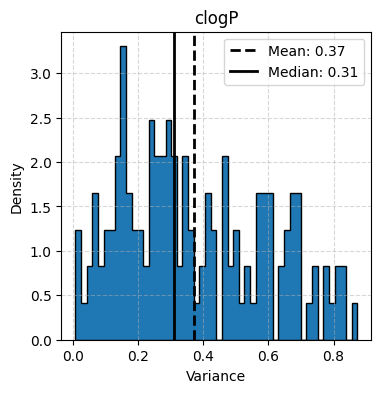

In [25]:
plot_variance_distribution(y_test_var, 'clogP')

and we can the mean and median estimated aleatoric uncertainty are not zero, as maybe we could have expected as the data should not have any noise. This illustrates that the methods is approximate, but nonetheless the uncertainty values are low as they should be for noiseless data.


Now lets see if the uncertainty quantification are well-calibrated:

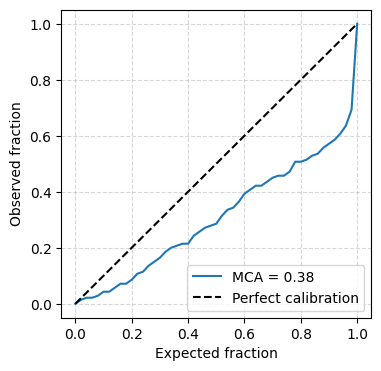

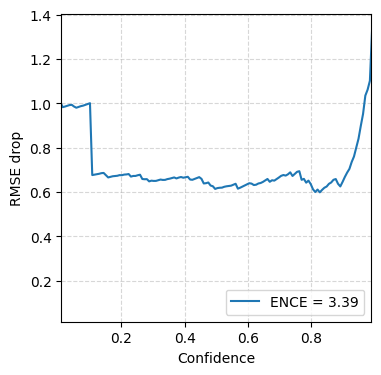

In [26]:
y_true = data[data.Subset == 'Test']['clogP'].values
y_mean = y_test_mean.detach().numpy()
y_var = y_test_var.detach().numpy()

plot_calibration_curve(y_true, y_mean, y_var)
plot_rmsedrop(y_true, y_mean, y_var)

The calibration is not great: there is no systematic RMSE-drop and the model is clearly overconfident. This is not suprising as the aleatoric uncertainty is only a part of the total predictive uncertainty.

### Epistemic uncertainty

Now lets try to estimate the epistemic uncertainty of our models with Monte Carlo dropout. Here, we build a classical neural network with a _**sigle output node**_ and train it based on the classic [mean squared error loss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss). However, during prediction making, we create a virtual ensemble model to get the mean prediction and the epistemic uncertainty by making predictions with 10 versions of the models where 20% of the nodes are silenced (selected add radom). 

In [48]:
class NeuralNetwork(nn.Module):
    """
    Simple neural network with two fully connected layers.
    
    Parameters
    ----------
    input_size : int
        Number of input features.
    hidden_size : int
        Number of hidden units.
    dropout : float
        Dropout rate.
    """
    def __init__(self, input_size, hidden_size, dropout=0.2):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 1),
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

As originally MC dropout was developped for model regularization during training (to avoid overfitting), and here we want to use it for multiple predictions, we need to create two helper functions to disable dropout layers during training and enabling them during evaluation.

In [28]:
def disable_dropout(model):
    """ Function to disable the dropout layers during training """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.eval()

def enable_dropout(model):
    """ Function to enable the dropout layers during evaluation """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

Once againg, lets create some helper functions to train and evaluate the model.

In [50]:
def trainWithoutDropout(dataloader, model, epochs):

    device = torch.device("cpu")
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    for epoch in range(epochs):
        model.train()
        disable_dropout(model) #disable dropout layers during training

        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Make predictions
            pred = model(X)

            # Compute loss
            loss = loss_fn(y, pred)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if epoch % 100 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch} - loss: {loss.item():>7f}")

def predictWithDropout(dataloader, model, n_samples=10):
    device = torch.device("cpu")
    model.eval()
    enable_dropout(model)
    preds = np.empty((len(dataloader.dataset), n_samples))
    for sample in range(n_samples):
        preds_sample = []
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            with torch.no_grad():
                pred = model(X)
            preds_sample.append(pred)
        preds_sample = torch.cat(preds_sample)
        preds[:, sample] = preds_sample.detach().numpy().squeeze()

    mean = torch.Tensor(preds.mean(axis=1))
    var = torch.Tensor(preds.var(axis=1))

    return mean, var

In [53]:
seed_everything(seed) #ensure reproducibility of results across runs
model = NeuralNetwork(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, dropout=0.2)
trainWithoutDropout(train_loader, model, epochs=EPOCHS)
y_test_mean, y_test_var = predictWithDropout(test_loader, model, n_samples=100)

Epoch 0 - loss: 16.251812
Epoch 99 - loss: 2.642090


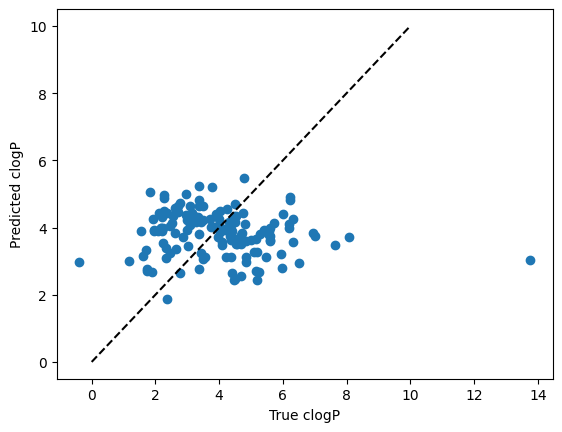

In [54]:
# Plot correlation between predicted and true values
y_true = data[data.Subset == 'Test']['clogP'].values
y_mean = y_test_mean.detach().numpy()

plt.plot(y_true, y_mean, 'o')
plt.xlabel('True clogP')
plt.ylabel('Predicted clogP')
plt.plot([0, 10], [0, 10], 'k--')

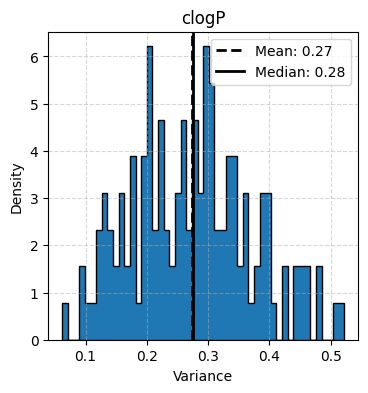

In [55]:
plot_variance_distribution(y_test_var, 'clogP')

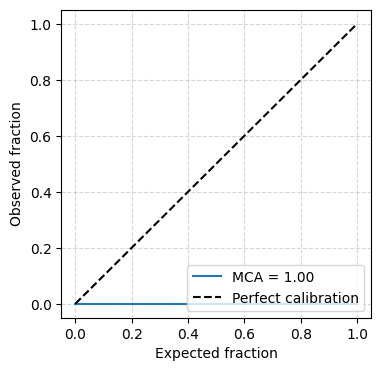

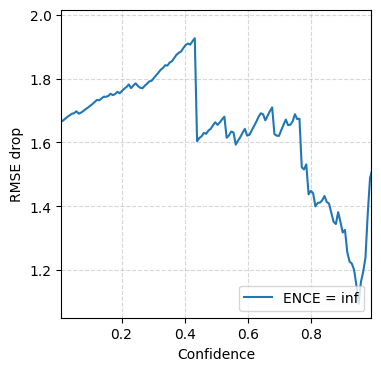

In [33]:
y_true = data[data.Subset == 'Test']['clogP'].values
y_mean = y_test_mean.detach().numpy()
y_var = y_test_var.detach().numpy()

plot_calibration_curve(y_true, y_mean, y_var)
plot_rmsedrop(y_true, y_mean, y_var)

### Total uncertainty in regression models

We can approximate the predictive variance as a combination of aletoric and epistemic uncertanties from the MVE and MC dropout (see [nn_total_uncertainty.py](nn_total_uncertainty.py)).

In [34]:
from nn_total_uncertainty import MVENetworkWithDropout, train, predict

seed_everything(seed) #ensure reproducibility of results across runs
model = MVENetworkWithDropout(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, dropout=0.2)
train(train_loader, model, epochs=EPOCHS)
y_test_mean, y_test_var = predict(test_loader, model, n_samples=100)

Epoch 0 - loss: 110.196770
Epoch 99 - loss: 3.572815


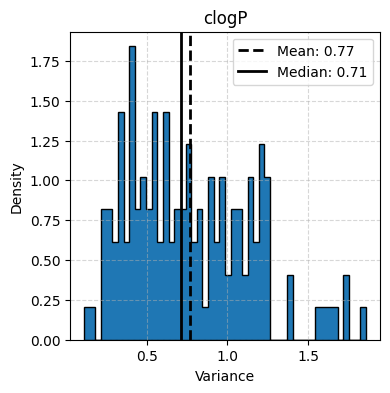

In [35]:
plot_variance_distribution(y_test_var, 'clogP')

As we could have expected the total uncertainty is larger than the aleatoric and epistemic uncertainty. 
This is because the aleatoric uncertainty is the variance of the noise in the data and the epistemic uncertainty is the variance of the model parameters. 
The total uncertainty is the sum of these two uncertainties.

Also below, we see that now we have a well-calibrated model!

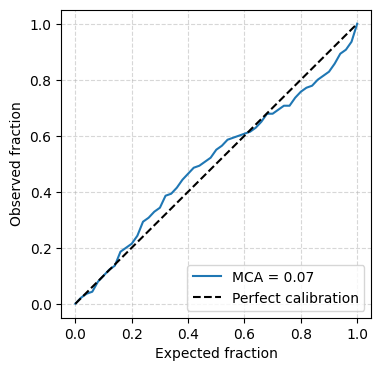

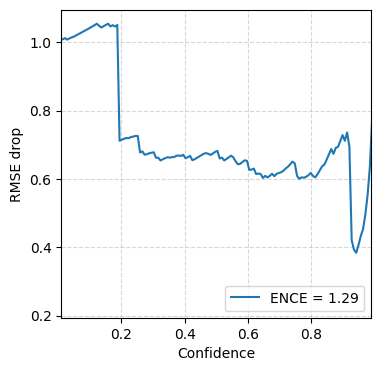

In [36]:
y_true = data[data.Subset == 'Test']['clogP'].values
y_mean = y_test_mean.detach().numpy()
y_var = y_test_var.detach().numpy()

plot_calibration_curve(y_true, y_mean, y_var)
plot_rmsedrop(y_true, y_mean, y_var)

## Active learning

Now, lets build active learning scheme for the prediction of clogP. 
The most important choice in a active learning strategy is the selection criteria. 
If uncertainty estimations are available they are a sensible choice for the selection criteria, 
but active learning strategies can also be applied without uncertainty estimates.

In the assigment, you will use the uncertainty estimates as selection criteria. 
Therefore, in this tutorial, we will show an other approach to select the most informative data points for the next training step.
Here, we will use the Tanimoto similarity between the compounds in the training set and the compounds in the learning pool. 
At each iteration, we'll the molecules with largest distance to the training set.

We can use `NeuralNetwork` model from above, but we need to create new `train` and `test` functions:

In [90]:
def train(dataloader, model, epochs):

    device = torch.device("cpu")
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

    for epoch in range(epochs):
        model.train()
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            # Make predictions
            pred = model(X)

            # Compute loss
            loss = loss_fn(y, pred)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

def predict(dataloader, model):
    device = torch.device("cpu")
    model.eval()
    preds = []
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        with torch.no_grad():
            pred = model(X)
        preds.append(pred)
    preds = torch.cat(preds).detach().numpy().squeeze()

    return preds

We also create an `evaluate` function to calculate the RMSE and R2 scores from the predictions to evaluate the performance of the model.

In [68]:
from sklearn.metrics import r2_score, mean_squared_error

def evaluate(y_true, y_pred):

    """
    Compute the root mean squared error, and R2 score
    
    Parameters
    ----------
    y_true : numpy array
        True values
    y_pred : numpy array
        Predicted values
        
    Returns
    -------
    rmse : float
        Root mean squared error
    r2 : float
        R2 score
    """
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    return rmse, r2

And most importantly, lets create function to select new training molecules based on the Tanimoto similarity:

In [83]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem

def minimum_interset_Tanimoto_distance(smiles_list, reference_smiles_list):

    """
    Function to calculate the minimum interset Tanimoto distance between a list of SMILES strings and a reference list of SMILES strings.
    
    Parameters
    ----------
    smiles_list : list
        List of SMILES strings.
    reference_smiles_list : list
        List of reference SMILES strings.
    
    Returns
    -------
    min_dist : float
        Minimum interset Tanimoto distance.
    """

    # Calculate Morgan fingerprints for both sets of SMILES strings
    fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048) for smiles in smiles_list]
    reference_fps = [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(smiles), 2, nBits=2048) for smiles in reference_smiles_list]

    min_dist = np.zeros(len(fps))

    # Calculate Tanimoto distance between each SMILES string and the reference set
    for i, fp in enumerate(fps):
        dist = DataStructs.BulkTanimotoSimilarity(fp, reference_fps)
        min_dist[i] = np.min(dist)

    return min_dist

def update_training_set(data, nmolecules = 20):

    """
    Function to update the training set by selecting the molecules with the highest minimum interset Tanimoto distance.

    Parameters
    ----------
    data : pandas DataFrame
        DataFrame containing the molecules
    nmolecules : int
        Number of molecules to select

    Returns
    -------
    data : pandas DataFrame
        Updated DataFrame containing the molecules
    """

    smiles_list = data[data.Subset == 'Learn']['SMILES'].values
    reference_smiles_list = data[data.Subset == 'Train']['SMILES'].values

    # Calculate minimum interset Tanimoto distance
    dist = minimum_interset_Tanimoto_distance(smiles_list, reference_smiles_list)

    # Select molecules with the highest minimum interset Tanimoto distance
    if nmolecules < len(smiles_list):
        idx = np.argsort(dist)[::-1]
        selected_smiles_list = [smiles_list[i] for i in idx[:nmolecules]]
    else:
        selected_smiles_list = smiles_list

    # Update training set
    data.loc[data.SMILES.isin(selected_smiles_list), 'Subset'] = 'Train'

    return data

Now we create the start our active learning loop. We start by training the model on the initial training set, and then we update the training set by selecting the molecules with the highest minimum interset Tanimoto distance. We then train the model on the updated training set, and repeat this process until we have selected all the molecules.

Iteration: 0, RMSE: 1.751, R2: -0.088
Iteration: 1, RMSE: 1.876, R2: -0.249
Iteration: 2, RMSE: 1.842, R2: -0.204
Iteration: 3, RMSE: 1.819, R2: -0.174
Iteration: 4, RMSE: 1.798, R2: -0.148
Iteration: 5, RMSE: 1.804, R2: -0.155
Iteration: 6, RMSE: 1.796, R2: -0.144
Iteration: 7, RMSE: 1.796, R2: -0.144
Iteration: 8, RMSE: 1.797, R2: -0.146
Iteration: 9, RMSE: 1.759, R2: -0.098
Iteration: 10, RMSE: 1.754, R2: -0.092
Iteration: 11, RMSE: 1.751, R2: -0.088
The learning set has been exhausted


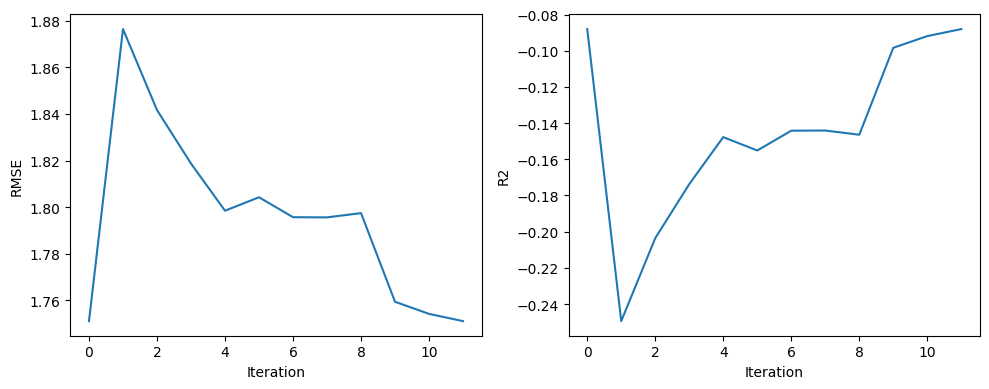

In [101]:
rmse_list, r2_list = [], [] #store results per iteration

df = data.copy()

for i in range(1000):

    if i > 0:
        # Update training set
        df = update_training_set(df, nmolecules=20)
        train_loader = create_dataloader(df, 'Train', 'clogP', 'MACCS', batch_size=BATCH_SIZE)
    
    # Train model
    seed_everything(seed) #ensure reproducibility of results across runs
    model = NeuralNetwork(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, dropout=0.0) 
    train(train_loader, model, epochs=EPOCHS)

    # Predict
    y_true = df[df.Subset == 'Test']['clogP'].values
    y_pred = predict(test_loader, model)
    rmse, r2 = evaluate(y_true, y_pred)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print('Iteration: {:d}, RMSE: {:.3f}, R2: {:.3f}'.format(i, rmse, r2))

    if 'Learn' not in df.Subset.values:
        # The learning set has been exhausted
        print('The learning set has been exhausted')
        break

# Plot evolution of RMSE and R2 score
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].plot(rmse_list)
ax[0].set_xlabel('Iteration')
ax[0].set_ylabel('RMSE')

ax[1].plot(r2_list)
ax[1].set_xlabel('Iteration')
ax[1].set_ylabel('R2')